This code simultaneously solves equation(s) 15 in the paper by Voinova: https://arxiv.org/pdf/cond-mat/9805266.pdf using eperimentally measured values of $\Delta$f and $\Delta$D to obtain calculated values of $\mu$ and $\eta$.

In [43]:
import numpy as np
import matplotlib.pyplot as plt

Define equation 15:

In [44]:
#%% calculate delta f and delta D using Voinona Voigt model
def voigt(mu_f, eta_f):
    ''' The Voinova equations come from eqns (24) and (25) in the paper by 
        Voinova: Vionova, M.V., Rodahl, M., Jonson, M. and Kasemo, B., 1999.
        Viscoelastic acoustic response of layered polymer films at fluid-solid
        interfaces: continuum mechanics approach. Physica Scripta,
        59(5), p.391.
    
        Reference: https://github.com/88tpm/QCMD/blob/master
        /Mass-specific%20activity/Internal%20functions/voigt_rel.m
            
       Solves for Delta f and Delta d of thin adlayer on quartz resonator.
       Differs from voight because calculates relative to unloaded resonator.
       
      Input
           density1 = density of adlayer in kg m-3
           shear1 = elastic shear modulus of adlayer in Pa
           viscosity1 = dynamic viscosity of adlayer in Pa s
           thickness1 = thickness of adlayer in m
           densitybulk = density of bulk Newtonian fluid in kg m-3
           viscositybulk = dynamic viscosity of bulk Newtonian fluid in kg m-3
           f0 = resonator fundamental frequency in s-1
       Output
           frequency = frequency change of resonator
           dissipation =  dissipation change of resonator
    '''
    # eqn 14
    kappa_f = eta_f-(1j*mu_f/w)
    # eqn 13
    x_f = np.sqrt(-rho_f*np.square(w)/(mu_f + 1j*w*eta_f))
    x_b = np.sqrt(1j*rho_b*w/eta_b)
    # eqn 11 after simplification with h1 = h2 and h3 = infinity
    A = (kappa_f*x_f+eta_b*x_b)/(kappa_f*x_f-eta_b*x_b)
    # eqn 16
    beta = kappa_f*x_f*(1-A*np.exp(2*x_f*h_f))/(1+A*np.exp(2*x_f*h_f))
    beta0 = kappa_f*x_f*(1-A)/(1+A)
    # eqn 15
    df = np.imag((beta-beta0)/(2*np.pi*rho_q*h_q))
    dd = -np.real((beta-beta0)/(np.pi*f0*n*rho_q*h_q))*1e6
    
    return df, dd

In [45]:
#%% find difference between two ordered pairs
def find_diff2D(p1, p2):
    #finds the distance between two ordered pairs of points in 2D
    #each point p1 and p2 must be an ordered pair with two elements
    xdiff = np.square(p2[0] - p1[0])
    ydiff = np.square(p2[1] - p1[1])
    diff = np.sqrt(xdiff + ydiff)
    return diff

Set physical constants of our system:

In [46]:
#%% set sone constants of the model
f0 = 5e6 #fundamental resonant frequency of crystal
n = 9 #harmonic number
w = 2*np.pi*f0*n #angular frequency 
mu_q = 2.947e10 #shear modulus of AT-cut quatz in Pa
rho_q = 2648 #density of quartz (kg/m^3)
h_q = np.sqrt(mu_q/rho_q)/(2*f0) #thickness of quartz
h_f = 5e-7 #film thickness in m
rho_f = 1000 #film density in kg/m^3
rho_b = 1.1839 #density of bulk air (25 C) in kg/m^3
eta_b = 18.6e-6 #viscosity of bulk air (25 C) in Pa s

To find numerical solutions, a grid of $\mu$ and $\eta$ is constructed:

In [47]:
#%% set size of grid to search
step_num = 250
mu_range = np.linspace(2.5e5, 5.7e5, step_num).astype(float)
eta_range = np.linspace(1e-6, 3e-4, step_num).astype(float)
print('grid contains %d points' %step_num**2)

grid contains 62500 points


In [48]:
df_exp = -4700
dd_exp = 116.236

print('Measured value of delta f = '+format(df_exp))
print('Measured value of delta D = '+format(dd_exp))

Measured value of delta f = -4700
Measured value of delta D = 116.236


In [49]:
# iterate over each point in grid to construct surfaces of delta f and delta D
dfm=[]
ddm=[]
for i in range(len(mu_range)-1):
    for j in range(len(eta_range)):
        #calculate delta f and delta d at each grid point  
        df0, dd0 = voigt(mu_range[i], eta_range[j])
        df1, dd1 = voigt(mu_range[i+1], eta_range[j])
        
        #check if surface intersects planes of experimental df and dd
        if df1 <= df_exp <= df0 or df0 <= df_exp <= df1:
            dfm.append([mu_range[i], eta_range[j]])
        if dd1 <= dd_exp <= dd0 or dd0 <= dd_exp <= dd1:  
             ddm.append([mu_range[i], eta_range[j]])
dfm = np.array(dfm)
ddm = np.array(ddm)

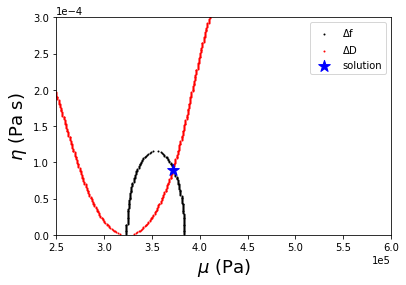

In [50]:
#--------------------------plot solution contours ------------------
fig = plt.figure()
ax = plt.gca()

ax.scatter(dfm[:,0], dfm[:,1], s=1, c='k', label='$\Delta$f')
ax.scatter(ddm[:,0], ddm[:,1], s=1, c='r', label='$\Delta$D')
    

#-------find intersection of df and dd contours -------------------    
all_diffs=[]
for dfm_val in dfm:
    for ddm_val in ddm:
        #find point closest to both contours 
        all_diffs.append([dfm_val[0], ddm_val[1], 
                          find_diff2D(dfm_val, ddm_val)])
    
all_diffs=np.array(all_diffs)    
min_diff_ind = np.argmin(all_diffs[:,2])
mu_sol0 = all_diffs[min_diff_ind][0] 
eta_sol0 = all_diffs[min_diff_ind][1]

#plot solution
plt.scatter(mu_sol0, eta_sol0, s=150, marker='*', label='solution', c='b')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlim([min(mu_range),6e5])
ax.set_ylim([0,max(eta_range)])
ax.set_xlabel('$\mu$ (Pa)', fontsize=18)
ax.set_ylabel('$\eta$ (Pa s)', fontsize=18)
plt.legend(loc='upper right')
plt.show()

In the above plot, the red contour line shows intersection of the surface with $\Delta$D and the black line shows intersection with $\Delta$f. Intersection of the two contour lines is the solution for $\eta$ and $\mu$. 